<h1 align="center">Implementasi CNN BLSD Oleh Bima</h1>

<H1>IMPORT Libbary</H1>

In [1]:
import numpy as np 
import pandas as pd 
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from tensorflow import keras

from keras.api.models import *
from keras.api.layers import *
from keras.api.utils import *
from keras.api.preprocessing import *

#from keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
#from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from tensorflow.keras.utils import to_categorical


<h1> fungsi graph </h1>

In [2]:
import plotly.graph_objects as go
def display_training_curves(training, validation, yaxis):
    ylabel = "{}".format(yaxis)
    title = "{} vs. Epochs".format(yaxis)
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Train"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Val"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()
    

# input img path dan explore data 

In [52]:

main_folder = r"F:\Model for skripsi\dataset\BananaLSD\AugmentedSet"

In [4]:

train_ratio = 0.8  # 80% untuk training, 20% untuk validasi

train_files = {}
val_files = {}

random.seed(42)

In [5]:
# Iterate class folders
for class_folder in os.listdir(main_folder):
    class_path = os.path.join(main_folder, class_folder) 
    images = os.listdir(class_path) 
    
    random.seed(42)    
    random.shuffle(images)
    
    split_index = int(len(images) * train_ratio)
    
    train_files[class_folder] = images[:split_index] 
    val_files[class_folder] = images[split_index:]


In [6]:
image_width, image_height = 224, 224
num_classes = len(train_files)
print(num_classes)

6


In [7]:
train_data = []
train_labels = []
val_data = []
val_labels = []

# Load and preprocess train set images
for class_folder, images in train_files.items():
    for image in images:
        image_path = os.path.join(main_folder, class_folder, image)
        img = load_img(image_path, target_size=(image_width, image_height))
        img_array = img_to_array(img)
        train_data.append(img_array)
        train_labels.append(class_folder)

# Load and preprocess test set images
for class_folder, images in val_files.items():
    for image in images:
        image_path = os.path.join(main_folder, class_folder, image)
        img = load_img(image_path, target_size=(image_width, image_height))
        img_array = img_to_array(img)
        val_data.append(img_array)
        val_labels.append(class_folder)

# Convert the data and labels to NumPy arrays
train_data = np.array(train_data)
val_data = np.array(val_data)

In [8]:
# dictionary map class folder nama ke interger
class_label_map = {class_folder: i for i, class_folder in enumerate(train_files.keys())}

# Convert train and val labels ke integer labels
train_labels = np.array([class_label_map[label] for label in train_labels]) 
val_labels = np.array([class_label_map[label] for label in val_labels])

# Convert class labels ke one-hot encoding
train_labels = to_categorical(train_labels, num_classes)
val_labels = to_categorical(val_labels, num_classes)

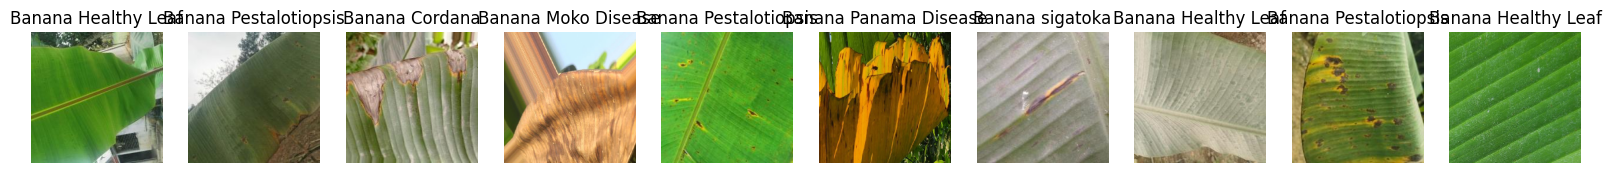

In [9]:
# menampilkan kumpulan gambar beserta labelnya
def display_image_batch(images, labels, class_names, batch_size=10):
    fig, axes = plt.subplots(1, batch_size, figsize=(20, 5))
    for i in range(batch_size):
        axes[i].imshow(images[i] / 255.0)  # Normalize pixel values
        axes[i].set_title(class_names[np.argmax(labels[i])])
        axes[i].axis('off')
    plt.show()

batch_size_to_display = 10 
random_indices = np.random.choice(len(train_data), size=batch_size_to_display, replace=False)
batch_images = train_data[random_indices]
batch_labels = train_labels[random_indices]

reverse_class_label_map = {v:k for k,v in class_label_map.items()}

class_names = [reverse_class_label_map[i] for i in range(len(reverse_class_label_map))]

display_image_batch(batch_images, batch_labels, class_names, batch_size=batch_size_to_display)

<h1>Load pre-trained ResNet50 model</h1>

In [51]:
#from tensorflow.keras.applications import ResNet50
from keras.api.applications import ResNet50,MobileNet


resnet = MobileNet(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

# Freeze pre-trained layers biar gak berubah bim
for layer in resnet.layers:
    layer.trainable = False

In [53]:
model = tf.keras.backend.clear_session()

model = Sequential()
model.add(resnet)
model.add(Flatten())# buat model baru di atas model resnet
model.add(Dropout(0.5))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
batch_size = 32
epochs = 5
history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_labels))

Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4200 - loss: 3.6056 - val_accuracy: 0.6338 - val_loss: 1.0732
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.6328 - loss: 0.9315 - val_accuracy: 0.6495 - val_loss: 0.9263
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7245 - loss: 0.6965 - val_accuracy: 0.7293 - val_loss: 0.7941
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8000 - loss: 0.4872 - val_accuracy: 0.7887 - val_loss: 0.7062
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8278 - loss: 0.4416 - val_accuracy: 0.7465 - val_loss: 0.7273


In [54]:
# Evaluate the model
loss, accuracy = model.evaluate(val_data, val_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7737 - loss: 0.6610
Test Loss: 0.7272903323173523
Test Accuracy: 0.7464788556098938


In [19]:
# Evaluate the model and get the predicted labels
predictions = model.predict(val_data)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = np.argmax(val_labels, axis=1)

# Compute the confusion matrix
confusion = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels)

# Convert the confusion matrix to a NumPy array
confusion = confusion.numpy()

20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

# Make predictions on the validation set
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(val_labels, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')


print("Accuracy:", accuracy)
print("F1-score:", f1)
print("Recall:", recall)
print("Precision:", precision)

# Generate classification report
print(classification_report(y_true, y_pred_classes))

# Generate confusion matrix
print(confusion_matrix(y_true, y_pred_classes))

20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step
Accuracy: 0.8607198748043818
F1-score: 0.8596824548609238
Recall: 0.8607198748043818
Precision: 0.8657377251157363
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       130
           1       0.80      0.95      0.87       120
           2       0.78      0.75      0.76        63
           3       0.83      0.57      0.68        42
           4       0.79      0.86      0.82       139
           5       0.95      0.88      0.91       145

    accuracy                           0.86       639
   macro avg       0.85      0.82      0.83       639
weighted avg       0.87      0.86      0.86       639

[[119   4   0   0   5   2]
 [  0 114   0   0   6   0]
 [  0   6  47   5   5   0]
 [  0   2  13  24   3   0]
 [  1  15   0   0 119   4]
 [  4   1   0   0  13 127]]


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (4).

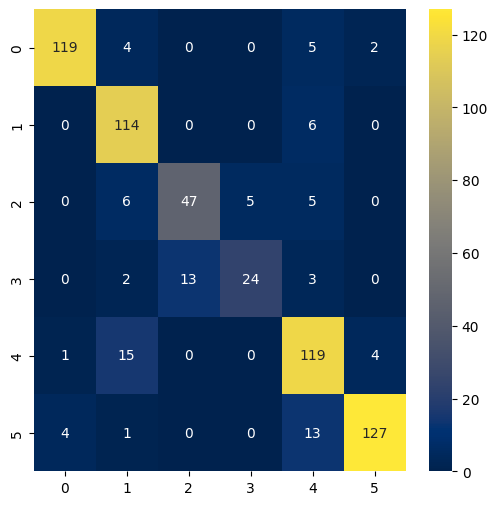

In [50]:
# Display the confusion matrix
plt.figure(figsize=(num_classes, num_classes))
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="cividis")
# Modify the labels
new_x_labels = ["Banana Cordana","Banana Healthy Leaf","Banana Pestalotiopsis","Banana Sigatoka"]
new_y_labels = ["Banana Cordana","Banana Healthy Leaf","Banana Pestalotiopsis","Banana Sigatoka"]
# Set the modified labels
ax.set_xticklabels(new_x_labels, rotation=90)
ax.set_yticklabels(new_y_labels, rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

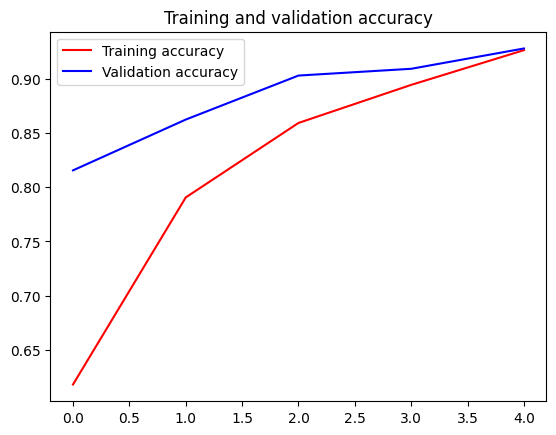

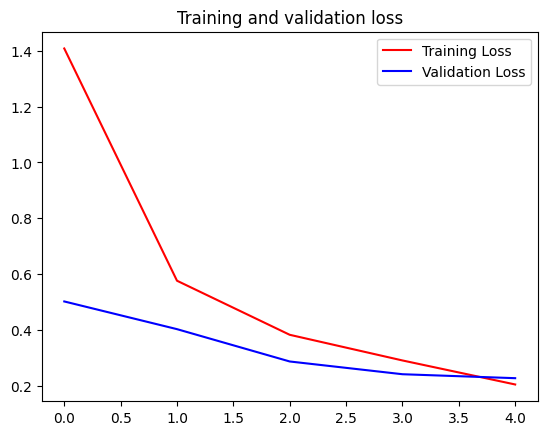

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<h2>save model</h2>

In [45]:
model.save('Resnet_uji3.keras')

In [46]:
model.save('model_uji3.hdf5')

In [47]:
model.save('Resnet_uji3.h5')

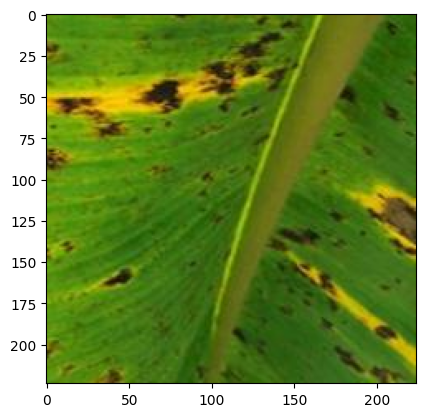

In [59]:
import skimage.io
import cv2
# kenapa warna merah jadi biru ?
img_link = r'dataset\BananaLSD\AugmentedSet\pestalotiopsis\7_aug.jpeg'

img = skimage.io.imread(img_link)
cv2.imwrite(img_link, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.imshow(img)
plt.show()

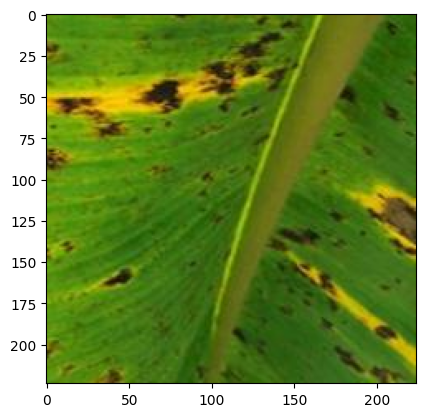

In [60]:
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [61]:
import numpy as np

# Preprocess the image
resized_image = resize / 255.0
input_image = np.expand_dims(resized_image, axis=0)

# Make predictions
yhat = model.predict(input_image)

# Get the predicted class index
predicted_class_index = np.argmax(yhat, axis=1)

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index[0]]

# Get the class probabilities
class_probabilities = yhat[0]

# Print the predicted class and probabilities
print("Predicted class:", predicted_class_name)
print("Class probabilities:", class_probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Predicted class: Banana Healthy Leaf
Class probabilities: [3.7572982e-03 6.2844580e-01 4.3454446e-04 4.0456725e-06 1.4703040e-02
 3.5265526e-01]


In [62]:
import numpy as np

# Preprocess the image
resized_image = resize / 255.0
input_image = np.expand_dims(resized_image, axis=0)

# Make predictions
yhat = model.predict(input_image)

# Get the predicted class indices in descending order of probability
predicted_class_indices = np.argsort(yhat, axis=1)[:, ::-1]

# Get the top two predicted class indices
top_classes = predicted_class_indices[0][:2]

# Get the class names for the top two classes
top_class_names = [class_names[i] for i in top_classes]

# Get the class probabilities for the top two classes
top_class_probabilities = yhat[0, top_classes]

# Print the top two predicted classes and their probabilities
print("Top Predicted Classes:", top_class_names)
print("Class Probabilities:", top_class_probabilities)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Top Predicted Classes: ['Banana Healthy Leaf', 'Banana sigatoka']
Class Probabilities: [0.6284458  0.35265526]
